<div style="width: 100%; height: 120px">
    <img src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Logotipo%20con%20Leyenda/LOGOTIPO%20leyenda%20color%20PNG.png", align="left"; width="250px">
</div>
<div style="float: center; width: 100%;">
    <h2>Exploratory Data Analysis of the <i> XL-Sum </i> dataset.</h2>
    <h4> As part of the MSc. dissertation: Applying large Spanish language models to Natural Language Processing tasks. </h4>
    <p>David Lorenzo Alfaro</p>
    <p>July, 2022</p>
</div>

In [28]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, GPT2LMHeadModel, RobertaForMaskedLM
from utils import get_tokenized_text, makedir
from typing import Iterable, Union
from pathlib import Path

## Preliminary data analysis

Let us first load the data from disk. It is a prerrequisite to either have it downloaded locally and located in a subdirectory called ``summaries/``, or make the appropriate modifications to the code to load it (e.g., via the HuggingFace's datasets library, `wget` request/s). In particular, we gathered the data from the *XL-Sum* official [GitHub repository](https://github.com/csebuetnlp/xl-sum)

In [10]:
DATA_DIR = Path('summaries/all')
TRAIN_PATH = Path(DATA_DIR, 'train.jsonl')
VAL_PATH = Path(DATA_DIR, 'val.jsonl')
TEST_PATH = Path(DATA_DIR, 'test.jsonl')

The necessary columns in the dataset are as listed:
* `text`: content of an article.
* `summary`: summary of an article.
* `id`: unique identifier of the article.

Indeed, other than article-summary pairs, all remaining information may be disregarded for the task that we are aimed at conducting.

Let us first load the training dataset to inspect some of its properties

In [11]:
df_train = pd.read_json(TRAIN_PATH, lines=True)[["id", "summary", "text"]]

Now, let us print the first $k$ elements of the training dataset

In [12]:
top_k=3
for i, (idx, s,t) in enumerate(zip(df_train.id, df_train.summary, df_train.text)):
    if i >= top_k:
        break
    print(f'id:{idx}\nText: {t} \nSummary: {s}', end="\n\n")

id:140930_ultnot_siria_onu_comida_ch
Text: De no recibir más dinero, las raciones de la ONU en Siria se terminarán en dos meses. En un informe al Consejo de Seguridad de la ONU, Amos dijo que las raciones del PMA destinadas a los 4.000.000 de sirios ya han sido recortadas para poder llegar a la mayor cantidad de personas posible. Amos también hizo un llamado a juntar suministros para proteger a los sirios del frío, en miras al próximo invierno. 
Summary: La directora de ayuda humanitaria de Naciones Unidas, Valerie Amos, advirtió que de no invertir más dinero, el Programa Mundial de Alimentos tendrá que detener sus operaciones en Siria en dos meses.

id:130809_ultnot_protesta_cachemira_protesa_aa
Text: Manifestantes hindúes gritan consignas contra el gobierno en la región de Cachemira administrada por India. Las manifestaciones tuvieron lugar después de los rezos especiales Eid, en la ciudad de Srinagar y en diversas ciudades de la región. La policía dice que la respuesta se produjo cu

Alternatively, one can resort to the built-in function `head` available in `pd.DataFrame` objects.

In [13]:
df_train.head(top_k)

,id,summary,text
0,140930_ultnot_siria_onu_comida_ch,La directora de ayuda humanitaria de Naciones ...,"De no recibir más dinero, las raciones de la O..."
1,130809_ultnot_protesta_cachemira_protesa_aa,La policía en la región de Cachemira administr...,Manifestantes hindúes gritan consignas contra ...
2,media-37220890,La naturaleza es un hueso duro de roer.,Así lo vemos en esta animación que muestra cóm...


### Impact of the limited dimensionality of the Language Models for Abstractive Summarization

Both GPT-2 and RoBERTa work on the subword level. All spanish language models from the MarIA project have a limited dimensionality of 512 tokens (or subwords). Furthermore, in order to generate summaries on a decoder-only system, both the text and the summary must fit into the model, which imposes further restrictions on the amount of instances in the dataset that can be processed in as as-is fashion (i.e., without needing to do any further modification in the text/summary of those instances before feeding them into the model). In summarization tasks, where the prominent practice is to strive for models with larger dimensionalities, this shortcoming is of vital relevance because it necessarily constraints the capabilities of the models to work with large texts.

### Training set

Let us inspect the number of *valid* instances (those that fit into the model) in the training set of data, using the GPT-2 model, and a RoBERTa2RoBERTa (a.k.a. RoBERTaShared) model. To that end, we will compute the number of article and summary tokens using the GPT-2 tokenizer for the spanish LM, and the number of article tokens using the RoBERTa tokenizer. Note that there is no need to compute the per-summary no. of tokens because this model will be subsequently used as the *warmed-up* models of an encoder-decoder system. However, we will also yield this statistic in order to further study some properties about the length of the summaries, which can be of vital relevance in the generation of the summaries.

Beforehand, let us define some useful functions that will enable us to comptue the number of tokens of a collection of tokens using a tokenizer (`calc_document_tokens`), and to plot histograms for article and summary length (also in terms of subwords) and a scatterplot relating these two random variables.

In [57]:
def calc_document_tokens(documents:Iterable, tokenizer:Union[str, Path]):
    """ Compute the number of tokens of a collection of documents using a pretrained tokenizer
    
    Parameters
    ----------
    documents : Iterable
        Collection of documents
        
    tokenizer : Union[str, Path]
        Model identifier of a predefined tokenizer hosted inside a model repo
         on huggingface.co
    """
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer)

    return [len(get_tokenized_text(doc, tokenizer)) for doc in documents]

def plot_stats(article_tokens:Iterable, summary_tokens:Iterable, hist_bins=20, scatter_marker_size=3):
    """ Plot some statistics about the article and summary tokens.
    
    Parameters
    ----------
    article_tokens : Iterable
        Collection of per-sample article tokens
        
    summary_tokens : Iterable
        Collection of per-sample summary tokens
    
    hist_bins : int
        Number of bins used to discretize data for histograms, defaults to 20
        
    scatter_marker_size : int
        Marker size of the scatter-plot, defaults to 3
    """
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
    ax1.hist(article_tokens, bins=hist_bins)
    ax2.hist(summary_tokens, bins=hist_bins)
    ax3.scatter(article_tokens, summary_tokens, s=scatter_marker_size)
    fig.set_size_inches(12,4)
    fig.tight_layout()

Now, let us compute the of tokens for the articles and summaries using the tokenizers of the GPT-2 and RoBERTa checkpoints.

In [17]:
checkpoint_gpt2 = "PlanTL-GOB-ES/gpt2-base-bne"
gpt2_article_tokens_train = calc_document_tokens(df_train.text, checkpoint_gpt2)
gpt2_summary_tokens_train = calc_document_tokens(df_train.summary, checkpoint_gpt2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [54]:
checkpoint_roberta = "PlanTL-GOB-ES/roberta-base-bne"
roberta_article_tokens_train = calc_document_tokens(df_train.text, checkpoint_roberta)
roberta_summary_tokens_train = calc_document_tokens(df_train.summary, checkpoint_roberta)

Token indices sequence length is longer than the specified maximum sequence length for this model (2183 > 512). Running this sequence through the model will result in indexing errors


To perform fine-tuning on a GPT-2 based model, at least 1 token should be reserved for a special token, which will serve as a separator between the article and the summary of each input sample. As you may see from the training sources, our particular take is to use the `<|sep|>` gram as the separator token, albeit a different sequence may be used, so long it does not conflict with an existing entry in the vocabulary of the tokenizer.

On the other hand, although we that the input maximum length is constraint to 512 tokens, a programmatic way to check such limitation is by accessing to the `config.n_positions` property of a GPT-2 HuggingFace checkpoint.

In [40]:
gpt2_max_n_tokens = GPT2LMHeadModel.from_pretrained(checkpoint_gpt2).config.n_positions
gpt2_valid_train = len(list(filter(lambda x: sum(x)<=gpt2_max_n_tokens-1, zip(gpt2_article_tokens_train,gpt2_summary_tokens_train))))
gpt2_invalid_train = len(gpt2_article_tokens_train) - gpt2_valid_train
# out of the box... how many articles can be processed by the gpt-2 model?
print(f'Using the "{checkpoint_gpt2}" model, {gpt2_valid_train} out of {len(gpt2_article_tokens_train)} training samples have <= {gpt2_max_n_tokens-1} tokens and thus are subject to application out of the box, whereas {gpt2_invalid_train} will cause an error unless further measures are taken (e.g., via truncation of info. in a meaningful fashion).')

Using the "PlanTL-GOB-ES/gpt2-base-bne" model, 9692 out of 38110 training samples have <= 511 tokens and thus are subject to application out of the box, whereas 28418 will cause an error unless further measures are taken (e.g., via truncation of info. in a meaningful fashion).


Let us further inspect some properties about the samples in the training dataset:
 * How are the length of the articles and summaries distributed?
 * Are the length of the article and its summary correlated?

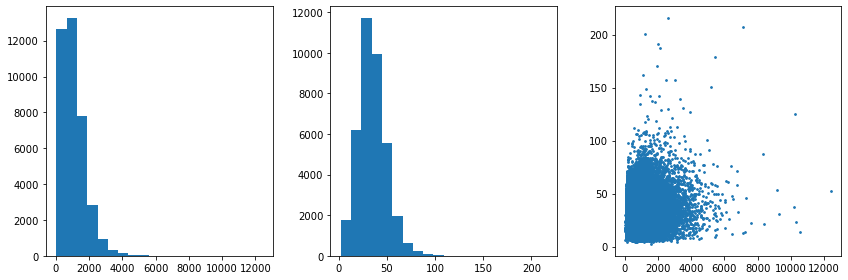

In [58]:
plot_stats(gpt2_article_tokens_train, gpt2_summary_tokens_train)

From the graphs we can tell:
* vast majority of the articles are around 500 to 1500 tokens long, whereas regular summary length revolves around 20 to 50 tokens.
* summary length seems to be independent from the length of the article.

We can also calculate some descriptive statistics summarizing the central tendency, dispersion and shape of the distribution of the article and summary tokens.

In [68]:
pd.DataFrame(list(zip(gpt2_article_tokens_train,gpt2_summary_tokens_train)), columns=["gpt2_article_tokens_train", "gpt2_summary_tokens_train"]).describe()

,gpt2_article_tokens_train,gpt2_summary_tokens_train
count,38110.000000,38110.000000
mean,1034.331068,34.986119
std,769.745530,14.608020
min,31.000000,2.000000
25%,466.000000,25.000000
50%,956.000000,34.000000
75%,1415.000000,43.000000
max,12421.000000,216.000000


Conclusions:
* Mean number of article tokens in the training set: $1034\pm770$. 770 is a large standard deviation, hence the mean is not a  very informative statistic (e.g., because of the influence of extreme values). The median may be more useful: $956$ tokens.

* Mean number of summary tokens in the training set: $35\pm15$. The value of the median is very similar: $34$.

Let us do the same for the RoBERTa LM, considering that the maximum number of tokens that the model can handle is two less than that reported of the model, being as we need to reserve two extra positions (or segments) for two special tokens. To double-check the maximum input of the length we can access to the `config.max_position_embeddings` property of the RoBERTa HuggingFace checkpoint.

In [30]:
roberta = RobertaForMaskedLM.from_pretrained(checkpoint_roberta)

In [39]:
roberta_max_n_tokens = RobertaForMaskedLM.from_pretrained(checkpoint_roberta).config.max_position_embeddings - 2 # reserve tokens for [CLS] and [EOS]
roberta_valid_train = len(list(filter(lambda x: x<=roberta_max_n_tokens, roberta_article_tokens_train)))
roberta_invalid_train = len(roberta_article_tokens_train) - roberta_valid_train
# out of the box... how many articles can be processed by the roberta model?
print(f'Using the "{checkpoint_roberta}" model, {roberta_valid_train} out of {len(roberta_article_tokens_train)} training samples have <= {roberta_max_n_tokens} tokens and thus are subject to application out of the box, whereas {roberta_invalid_train} will cause an error unless further measures are taken (e.g., via truncation of info. in a meaningful fashion).')

Using the "PlanTL-GOB-ES/roberta-base-bne" model, 10235 out of 38110 training samples have <= 512 tokens and thus are subject to application out of the box, whereas 27875 will cause an error unless further measures are taken (e.g., via truncation of info. in a meaningful fashion).


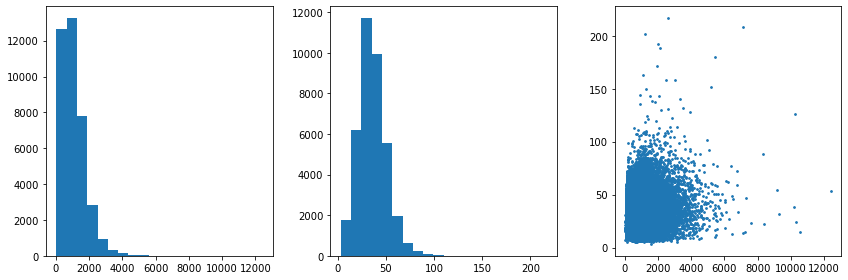

In [61]:
plot_stats(roberta_article_tokens_train, roberta_summary_tokens_train)

In [69]:
pd.DataFrame(list(zip(roberta_article_tokens_train,roberta_summary_tokens_train)), columns=["roberta_article_tokens_train", "roberta_summary_tokens_train"]).describe()

,roberta_article_tokens_train,roberta_summary_tokens_train
count,38110.000000,38110.000000
mean,1035.331068,35.986119
std,769.745530,14.608020
min,32.000000,3.000000
25%,467.000000,26.000000
50%,957.000000,35.000000
75%,1416.000000,44.000000
max,12422.000000,217.000000


Analogous conclusions can be inferred when using the RoBERTa tokenizer, with nearly negligible differences.

### Validation set

Now, let us conduct this experiment on the validation and test datasets:

In [42]:
df_val = pd.read_json(VAL_PATH, lines=True)[["id", "summary", "text"]]

In [41]:
gpt2_article_tokens_val = calc_document_tokens(df_val.text, checkpoint_gpt2)
gpt2_summary_tokens_val = calc_document_tokens(df_val.summary, checkpoint_gpt2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
gpt2_valid_val = len(list(filter(lambda x: sum(x)<=gpt2_max_n_tokens-1, zip(gpt2_article_tokens_val,gpt2_summary_tokens_val))))
gpt2_invalid_val = len(gpt2_article_tokens_val) - gpt2_valid_val
print(f'Using the "{checkpoint_gpt2}" model, {gpt2_valid_val} out of {len(gpt2_article_tokens_val)} validation samples have <= {gpt2_max_n_tokens-1} tokens and thus are subject to application out of the box, whereas {gpt2_invalid_val} will cause an error unless further measures are taken.')

Using the "PlanTL-GOB-ES/gpt2-base-bne" model, 814 out of 4763 validation samples have <= 511 tokens and thus are subject to application out of the box, whereas 3949 will cause an error unless further measures are taken.


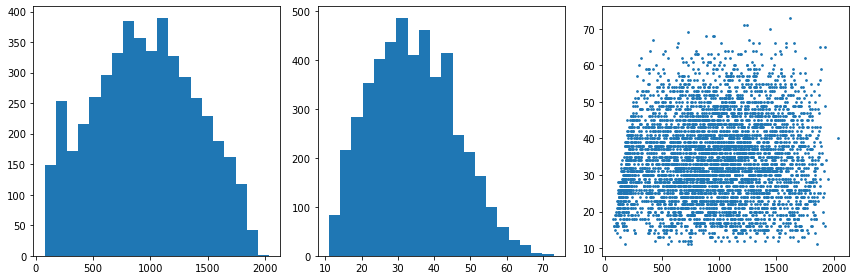

In [70]:
plot_stats(gpt2_article_tokens_val, gpt2_summary_tokens_val)

In [71]:
pd.DataFrame(list(zip(gpt2_article_tokens_val,gpt2_summary_tokens_val)), columns=["gpt2_article_tokens_val", "gpt2_summary_tokens_val"]).describe()

,gpt2_article_tokens_val,gpt2_summary_tokens_val
count,4763.000000,4763.000000
mean,950.719295,34.226748
std,446.983980,11.507983
min,75.000000,11.000000
25%,615.000000,25.000000
50%,951.000000,33.000000
75%,1286.000000,42.000000
max,2038.000000,73.000000


We can draw similar conclusions to those obtained for the training set:
* Vast majority of the articles are around 600 to 1200 tokens long, whereas regular summary length revolves around 20 to 45 tokens.
* Summary length seems to be independent from the length of the article.
* Mean number of article tokens in the validation set: $950\pm447$. Fairly close to the median: $951$ tokens.
* Mean number of summary tokens in the validation set: $34\pm12$. The value of the median is very similar: $33$.

In order to avoid verbosity, we eschew reproducing these experiments using the RoBERTa tokenizer, since very similar results are to expect.

In [55]:
roberta_article_tokens_val = calc_document_tokens(df_val.text, checkpoint_roberta)
roberta_summary_tokens_val = calc_document_tokens(df_val.summary, checkpoint_roberta)

Token indices sequence length is longer than the specified maximum sequence length for this model (780 > 512). Running this sequence through the model will result in indexing errors


In [46]:
roberta_valid_val = len(list(filter(lambda x: x<=roberta_max_n_tokens, roberta_article_tokens_val)))
roberta_invalid_val = len(roberta_article_tokens_val) - roberta_valid_val
print(f'Using the "{checkpoint_roberta}" model, {roberta_valid_val} out of {len(roberta_article_tokens_val)} training samples have <= {roberta_max_n_tokens} tokens and thus are subject to application out of the box, whereas {roberta_invalid_val} will cause an error unless further measures are taken.')

Using the "PlanTL-GOB-ES/roberta-base-bne" model, 903 out of 4763 training samples have <= 512 tokens and thus are subject to application out of the box, whereas 3860 will cause an error unless further measures are taken.


### Test set

In [48]:
df_test = pd.read_json(TEST_PATH, lines=True)[["id", "summary", "text"]]

In [49]:
gpt2_article_tokens_test = calc_document_tokens(df_test.text, checkpoint_gpt2)
gpt2_summary_tokens_test = calc_document_tokens(df_test.summary, checkpoint_gpt2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
gpt2_valid_test = len(list(filter(lambda x: sum(x)<=gpt2_max_n_tokens-1, zip(gpt2_article_tokens_test,gpt2_summary_tokens_test))))
gpt2_invalid_test = len(gpt2_article_tokens_test) - gpt2_valid_val
print(f'Using the "{checkpoint_gpt2}" model, {gpt2_valid_test} out of {len(gpt2_article_tokens_test)} test samples have <= {gpt2_max_n_tokens-1} tokens and thus are subject to application out of the box, whereas {gpt2_invalid_test} will cause an error unless further measures are taken.')

Using the "PlanTL-GOB-ES/gpt2-base-bne" model, 804 out of 4763 test samples have <= 511 tokens and thus are subject to application out of the box, whereas 3949 will cause an error unless further measures are taken.


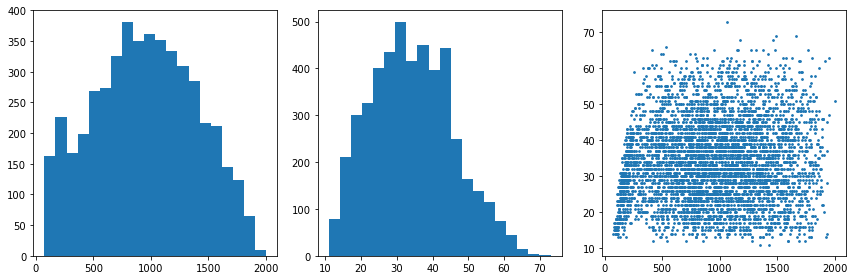

In [72]:
plot_stats(gpt2_article_tokens_test, gpt2_summary_tokens_test)

In [73]:
pd.DataFrame(list(zip(gpt2_article_tokens_test,gpt2_summary_tokens_test)), columns=["gpt2_article_tokens_test", "gpt2_summary_tokens_test"]).describe()

,gpt2_article_tokens_test,gpt2_summary_tokens_test
count,4763.000000,4763.000000
mean,948.605921,34.231787
std,444.319426,11.396173
min,75.000000,11.000000
25%,616.000000,26.000000
50%,951.000000,33.000000
75%,1283.000000,42.000000
max,2002.000000,73.000000


We can draw similar conclusions to those obtained for the training and validation set, which enable us to assert that, overall, **the number of article and summary tokens across the different datasets are independent and identically distributed**:
* Vast majority of the articles are around 600 to 1200 tokens long, whereas regular summary length revolves around 20 to 45 tokens.
* Summary length seems to be independent from the length of the article.
* Mean number of article tokens in the test set: $959\pm444$. Fairly close to the median: $951$ tokens.
* Mean number of summary tokens in the test set: $34\pm11$. The value of the median is very similar: $33$.

In order to avoid verbosity, we eschew reproducing these experiments using the RoBERTa tokenizer, since very similar results are to expect.

In [56]:
roberta_article_tokens_test = calc_document_tokens(df_test.text, checkpoint_roberta)
roberta_summary_tokens_test = calc_document_tokens(df_test.summary, checkpoint_roberta)

Token indices sequence length is longer than the specified maximum sequence length for this model (1248 > 512). Running this sequence through the model will result in indexing errors


In [52]:
roberta_valid_test = len(list(filter(lambda x: x<=roberta_max_n_tokens, roberta_article_tokens_test)))
roberta_invalid_test = len(roberta_article_tokens_test) - roberta_valid_test
print(f'Using the "{checkpoint_roberta}" model, {roberta_valid_test} out of {len(roberta_article_tokens_test)} training samples have <= {roberta_max_n_tokens} tokens and thus are subject to application out of the box, whereas {roberta_invalid_test} will cause an error unless further measures are taken.')

Using the "PlanTL-GOB-ES/roberta-base-bne" model, 897 out of 4763 training samples have <= 512 tokens and thus are subject to application out of the box, whereas 3866 will cause an error unless further measures are taken.


## Recap

Let us bring all data together to draw the final conclusions. To that end, and considering differences between the number of subwords using the different tokenizers, we will repeat the previous process using the training, validation and test sets altogether.

In [78]:
gpt2_article_tokens = gpt2_article_tokens_train + gpt2_article_tokens_val + gpt2_article_tokens_test
gpt2_summary_tokens = gpt2_summary_tokens_train + gpt2_summary_tokens_val + gpt2_summary_tokens_test

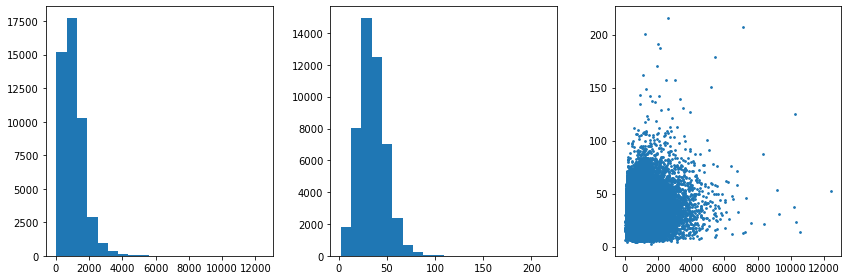

In [79]:
plot_stats(gpt2_article_tokens, gpt2_summary_tokens)

In [87]:
df_gpt2_tokens = pd.DataFrame(list(zip(gpt2_article_tokens,gpt2_summary_tokens)), columns=["gpt2_article_tokens", "gpt2_summary_tokens"])
df_gpt2_tokens.describe()

,gpt2_article_tokens,gpt2_summary_tokens
count,47636.000000,47636.000000
mean,1017.399509,34.834768
std,717.547947,14.036877
min,31.000000,2.000000
25%,506.000000,25.000000
50%,955.000000,34.000000
75%,1379.000000,43.000000
max,12421.000000,216.000000


* Vast majority of the articles are around 500 to 1300 tokens long, whereas regular summary length revolves around 25 to 45 tokens.
* Summary length seems to be independent from the length of the article.
* Mean number of article tokens in the training set: $1017\pm718$. Fairly close to the median: $955$ tokens.
* Mean number of summary tokens in the training set: $35\pm14$. The value of the median is very similar: $34$.

Some implications of these statistics is that when fine-tuning our models, no matter the data that is used to (i) train the models, (ii) validate or supervise the training process, and to (iii) assess goodness of the resulting models, if we aim at maximising performance metrics like ROUGE, one thing to bear in mind is that the summaries should have a length of around $35\pm14$ tokens. This is essentially due to the fact that, even if we solely use samples that can be entirely fitted into the model (i.e., without the need to trim/remove information from the original article and/or summary), the extent of the summary in terms of no. of subwords is independent of the size of the article. We can, indeed, double check it ourselves:

In [90]:
df_gpt2_tokens[df_gpt2_tokens.gpt2_article_tokens <= gpt2_max_n_tokens].describe()

,gpt2_article_tokens,gpt2_summary_tokens
count,12063.000000,12063.000000
mean,231.739120,34.641383
std,131.832378,11.038794
min,31.000000,4.000000
25%,126.000000,27.000000
50%,180.000000,34.000000
75%,337.000000,41.000000
max,512.000000,98.000000
